In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [10]:
df = pd.read_csv('Housing.csv')
print(df.info())
print("Skewness of price is: ",df['price'].skew())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None
Skewness of price is:  1.2122388370279802


Correlation with Price:
price        1.000000
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


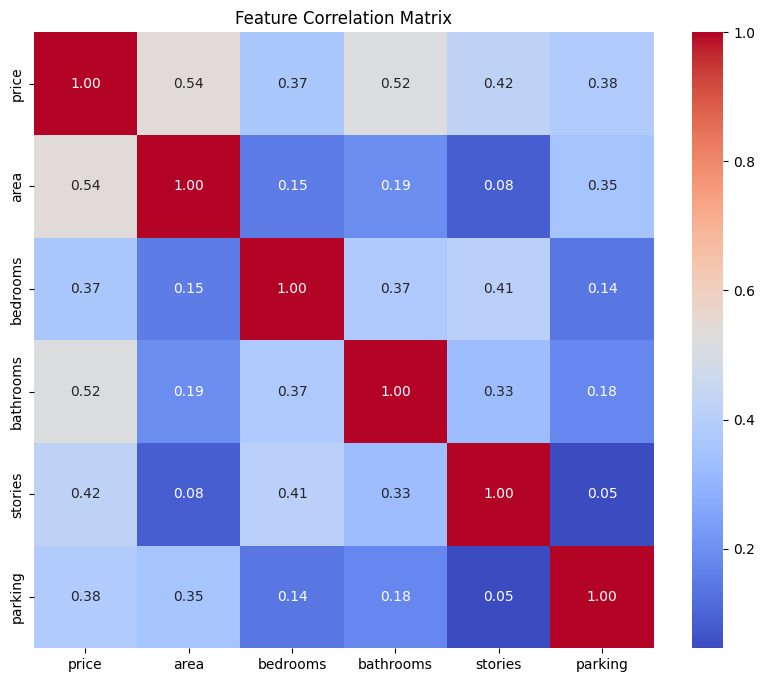

In [11]:
numeric_df = df.select_dtypes(include=['int64' , 'float64'])
corr_matrix = numeric_df.corr()
print("Correlation with Price:")
print(corr_matrix['price'].sort_values(ascending=False))

# 3. Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [12]:


numerical_features = ['area' , 'bedrooms', 'bathrooms' , 'stories' , 'parking']
categorical_features = ['mainroad', 'guestroom' , 'basement' , 'hotwaterheating','airconditioning','prefarea','furnishingstatus']

In [15]:
num_trans = Pipeline(
    steps=[
        ('imputer' , SimpleImputer(strategy='median')),
        ('scaling' , StandardScaler())
    ]
)

cat_trans = Pipeline(
    steps = [
        ('imputer' , SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first' , handle_unknown='ignore'))
    ]
)

preproc = ColumnTransformer(
    transformers=[
        ('num_trans' , num_trans , numerical_features),
        ('cat_trans' , cat_trans, categorical_features)
    ], remainder='drop'
)

In [29]:
final_pipeline = Pipeline(
    steps=[
        ('preproc' , preproc),
        ('model' , RandomForestRegressor(random_state=42, n_estimators=300))
    ]
)

In [30]:
X = df.drop('price', axis = 1)

y = np.log1p(df['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train
# The pipeline takes the dirty X_train, cleans it, and fits the model.
final_pipeline.fit(X_train, y_train)

print("Training Complete. The model has learned the patterns.")

Training Complete. The model has learned the patterns.


------------------------------------------------
Final R2 Score: 0.592 (Explains 59.2% of variance)
Average Error (MAE): $1,021,572.76
------------------------------------------------


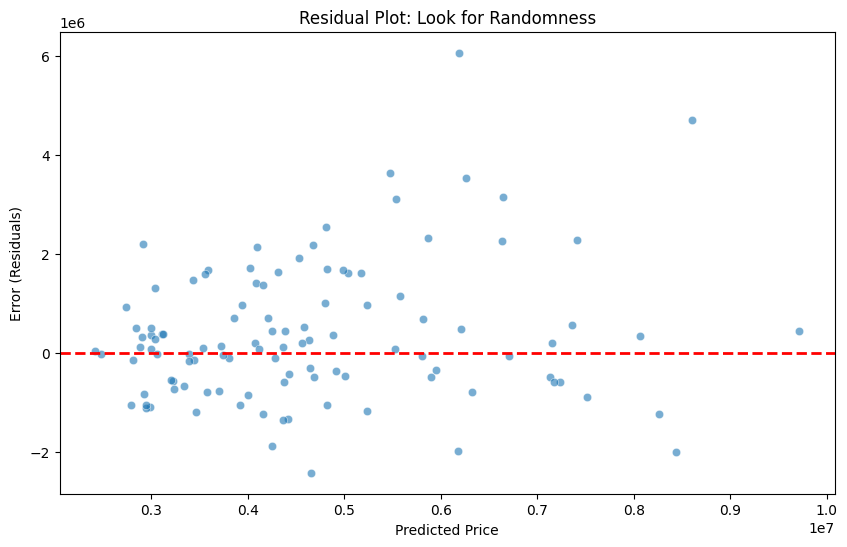

In [31]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Make Predictions (in Log Scale)
y_pred_log = final_pipeline.predict(X_test)

# 2. Reverse the Log Transform (Log -> Real Dollars)
# We used log1p, so we use expm1 to reverse it.
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# 3. Calculate Metrics
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print("------------------------------------------------")
print(f"Final R2 Score: {r2:.3f} (Explains {r2*100:.1f}% of variance)")
print(f"Average Error (MAE): ${mae:,.2f}")
print("------------------------------------------------")

# 4. Visual Diagnostic: The Residual Plot
residuals = y_test_actual - y_pred_actual

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_actual, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2) # The "Perfect Prediction" line
plt.xlabel("Predicted Price")
plt.ylabel("Error (Residuals)")
plt.title("Residual Plot: Look for Randomness")
plt.show()

C:\Users\harsh\AppData\Local\Temp\ipykernel_3304\4222580325.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


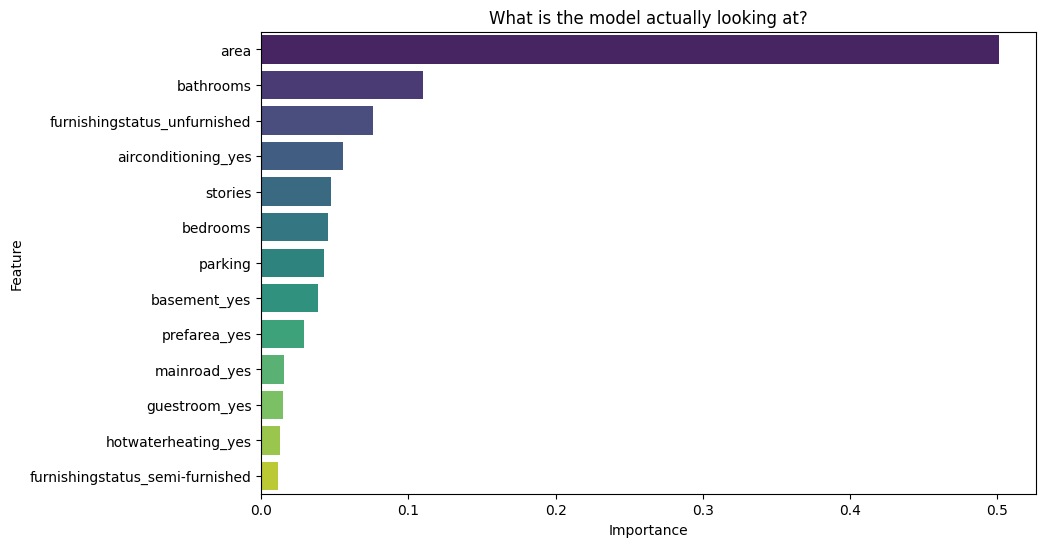

                            Feature  Importance
0                              area    0.501321
2                         bathrooms    0.109928
12     furnishingstatus_unfurnished    0.075973
9               airconditioning_yes    0.055522
3                           stories    0.047425
1                          bedrooms    0.045272
4                           parking    0.042577
7                      basement_yes    0.038291
10                     prefarea_yes    0.028773
5                      mainroad_yes    0.015768
6                     guestroom_yes    0.014906
8               hotwaterheating_yes    0.012978
11  furnishingstatus_semi-furnished    0.011265


In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Access the Model and Preprocessor from your Pipeline
model = final_pipeline.named_steps['model']
preprocessor = final_pipeline.named_steps['preproc']

# 2. Extract Feature Names
# This is the "Pro" way to get names after OneHotEncoding
cat_names = preproc.named_transformers_['cat_trans']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_names)

# 3. Get Importance Scores
importances = model.feature_importances_

# 4. Create a DataFrame to View Them
feat_imp = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 5. Visual Check
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title("What is the model actually looking at?")
plt.show()

print(feat_imp)